# 73 Strings Case study

#### I would like to use two different approches to solve the case study
#### Recommended IDE= Google Colab or Jupyter studio

#### Approach 1: Using BERT(transformation algorithm)- High accuracy, computaionally expensive.

#### Approach 2: Regular CNN- low accuracy, coputationally less expensive

#### Note: The regular CNN tend to overfit a lot, that's why I opted to use implement BERT algorithm. This BERT algorithm works perfectly with the test set and predicts almost every industry tag correctly.

## Approach 1: Using Bert(Transformer algorithm)



### Bert works better with tensorflow=1.15

### Install and import necessary libraries

Once after uninstalling and reinstalling tensorflow it is recommended to restart the runtime

In [ ]:

!pip uninstall tensorflow==2.2.0

!pip install tensorflow==1.15.0

!pip install bert-tensorflow

Uninstalling tensorflow-2.2.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
y
y
y
ERROR: Operation cancelled by user
     |████████████████████████████████| 412.3MB 32kB/s 
     |████████████████████████████████| 3.8MB 40.7MB/s 
     |████████████████████████████████| 512kB 37.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=7f238cd7a167ff1b840d4f57386f43f26c579f8439630e9b44fd5efc6ae9d7e3
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: -ensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which

     |████████████████████████████████| 71kB 2.0MB/s 


### Import drive and create a output directory for saving chechpoints

In [ ]:
from google.colab import drive
#drive.mount('/GD')

In [ ]:
OUTPUT_DIR = '/GD/My Drive/Colab Notebooks/73strings/ouput'

In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
#from sklearn.model_selection import train_test_split
import os
from sklearn import preprocessing 
import numpy as np
from sklearn import metrics

In [ ]:
print("tensorflow version : ", tf.__version__)
print("tensorflow_hub version : ", hub.__version__)

tensorflow version :  1.15.0
tensorflow_hub version :  0.8.0


In [ ]:
tf.train.Optimizer == tf.keras.optimizers.Optimizer

False

In [ ]:
import bert

In [ ]:
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [ ]:
tf.train.Optimizer=tf.compat.v1.train.Optimizer

### Read and preprocess the data

#### You can either upload it from your pc or from drive

In [ ]:
x=pd.read_excel('Training_Data_Set_for_Data_Science_Case_Study.xlsx')
y=pd.read_excel('Testing_Data_for_Data_Science_Case_Study.xlsx')

#### Encode the labels to numericals

In [ ]:
label_encoder = preprocessing.LabelEncoder() 
x['Industry Classification Tag_enc']= label_encoder.fit_transform(x['Industry Classification Tag'])
from sklearn.utils import shuffle
x = shuffle(x)

x.reset_index(inplace=True, drop=True)

### Split the training data
#### Training data= 90%
#### Validation Data=10%

In [ ]:
split_value=int(0.9 * x.shape[0])
train_data=x.iloc[:split_value]
val_data=x.iloc[split_value:]


In [ ]:
train_data.head()

,Company Name,Business Description,Industry Classification Tag,Industry Classification Tag_enc
0,"Microwave Filter Co., Inc","Microwave Filter Company, Inc. designs, develo...",Communications Equipment,11
1,Texas Capital Bancshares Inc,"Texas Capital Bancshares, Inc. is a bank holdi...",Regional Banks,50
2,Facebook Inc,"Facebook, Inc. is focused on building products...",Interactive Media & Services,34
3,Superior Industries International Inc,"Superior Industries International, Inc. is eng...",Auto Parts & Equipment,6
4,Snap-on Inc,Snap-on Incorporated is a manufacturer and mar...,Industrial Machinery,32


In [ ]:
train_data=train_data.drop(columns=['Company Name', 'Industry Classification Tag'])

In [ ]:
val_data=val_data.drop(columns=['Industry Classification Tag','Company Name'])

In [ ]:
test_set_data=y

In [ ]:
train_data['Industry Classification Tag_enc'].unique().size

62

In [ ]:
train_data['Business Description'] = list( map(str, train_data['Business Description']) )
val_data['Business Description'] = list( map(str, val_data['Business Description']) )
test_set_data['Business Description'] = list( map(str, test_set_data['Business Description']) )

In [ ]:
DATA_COLUMN = 'Business Description'
LABEL_COLUMN = 'Industry Classification Tag_enc'


In [ ]:
label_list =list(range(62)) 




In [ ]:
train_InputExamples = train_data.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val_data.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
train_InputExamples

0       <bert.run_classifier.InputExample object at 0x...
1       <bert.run_classifier.InputExample object at 0x...
2       <bert.run_classifier.InputExample object at 0x...
3       <bert.run_classifier.InputExample object at 0x...
4       <bert.run_classifier.InputExample object at 0x...
                              ...                        
5435    <bert.run_classifier.InputExample object at 0x...
5436    <bert.run_classifier.InputExample object at 0x...
5437    <bert.run_classifier.InputExample object at 0x...
5438    <bert.run_classifier.InputExample object at 0x...
5439    <bert.run_classifier.InputExample object at 0x...
Length: 5440, dtype: object

### We use the approach of transfer learning by loading a pretrained BERT model that's available in the link below

In [ ]:
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

In [ ]:
def create_tokenizer_from_hub_module():
  #Get the vocab file and casing info from the Hub module
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['microwave', 'filter', 'company', ',', 'inc', '.', 'designs', ',', 'develops', ',', 'manufactures', 'and', 'sells', 'electronic', 'filters', ',', 'both', 'for', 'radio', 'and', 'microwave', 'frequencies', ',', 'to', 'help', 'process', 'signal', 'distribution', 'and', 'to', 'prevent', 'unwanted', 'signals', 'from', 'disrupt', '##ing', 'transmit', 'or', 'receive', 'operations', '.', 'the', 'company', 'manufactures', 'radio', 'frequency', '(', 'rf', ')', 'filters', 'and', 'related', 'components', 'for', 'eliminating', 'interference', 'and', 'facilitating', 'signal', 'processing', 'for', 'such', 'markets', 'as', 'cable', 'television', ',', 'broadcast', ',', 'commercial', 'and', 'military', 'communications', ',', 'av', '##ion', '##ics', ',', 'radar', ',', 'navigation', 'and', 'defense', '.', 'the', 'company', 'designs', 'wave', '##guide', ',', 'strip', '##line', '/', 'micro', '##st', '##rip', ',', 'transmission', 'line', ',', 'miniature', '/', 'sub', '##mini', '##at', '##ure', 'and', 'lump

### Before we feed the data into the bert model, it must be formatted into an acceptable form for the bert model

In [ ]:


MAX_SEQ_LENGTH = 180


train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 5440


INFO:tensorflow:Writing example 0 of 5440


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] microwave filter company , inc . designs , develops , manufactures and sells electronic filters , both for radio and microwave frequencies , to help process signal distribution and to prevent unwanted signals from disrupt ##ing transmit or receive operations . the company manufactures radio frequency ( rf ) filters and related components for eliminating interference and facilitating signal processing for such markets as cable television , broadcast , commercial and military communications , av ##ion ##ics , radar , navigation and defense . the company designs wave ##guide , strip ##line / micro ##st ##rip , transmission line , miniature / sub ##mini ##at ##ure and lump ##ed constant filters . configurations include band ##pass , high ##pass , low ##pass , bands ##top , multiple ##x ##ers , tuna ##ble notch , tuna ##ble band ##pass , high power filters , amplitude equal ##ized , delay equal ##ized and filter networks . it offers products covering the freque

INFO:tensorflow:tokens: [CLS] microwave filter company , inc . designs , develops , manufactures and sells electronic filters , both for radio and microwave frequencies , to help process signal distribution and to prevent unwanted signals from disrupt ##ing transmit or receive operations . the company manufactures radio frequency ( rf ) filters and related components for eliminating interference and facilitating signal processing for such markets as cable television , broadcast , commercial and military communications , av ##ion ##ics , radar , navigation and defense . the company designs wave ##guide , strip ##line / micro ##st ##rip , transmission line , miniature / sub ##mini ##at ##ure and lump ##ed constant filters . configurations include band ##pass , high ##pass , low ##pass , bands ##top , multiple ##x ##ers , tuna ##ble notch , tuna ##ble band ##pass , high power filters , amplitude equal ##ized , delay equal ##ized and filter networks . it offers products covering the freque

INFO:tensorflow:input_ids: 101 18302 11307 2194 1010 4297 1012 5617 1010 11791 1010 22027 1998 15187 4816 17736 1010 2119 2005 2557 1998 18302 13139 1010 2000 2393 2832 4742 4353 1998 2000 4652 18162 7755 2013 23217 2075 19818 2030 4374 3136 1012 1996 2194 22027 2557 6075 1006 21792 1007 17736 1998 3141 6177 2005 15349 11099 1998 25505 4742 6364 2005 2107 6089 2004 5830 2547 1010 3743 1010 3293 1998 2510 4806 1010 20704 3258 6558 1010 7217 1010 9163 1998 3639 1012 1996 2194 5617 4400 28582 1010 6167 4179 1013 12702 3367 29443 1010 6726 2240 1010 12973 1013 4942 25300 4017 5397 1998 15116 2098 5377 17736 1012 22354 2421 2316 15194 1010 2152 15194 1010 2659 15194 1010 4996 14399 1010 3674 2595 2545 1010 24799 3468 18624 1010 24799 3468 2316 15194 1010 2152 2373 17736 1010 22261 5020 3550 1010 8536 5020 3550 1998 11307 6125 1012 2009 4107 3688 5266 1996 6075 2846 2013 1019 2014 5753 2000 2753 15453 4430 8743 2480 2005 6304 2105 1996 2088 1012 102 0


INFO:tensorflow:input_ids: 101 18302 11307 2194 1010 4297 1012 5617 1010 11791 1010 22027 1998 15187 4816 17736 1010 2119 2005 2557 1998 18302 13139 1010 2000 2393 2832 4742 4353 1998 2000 4652 18162 7755 2013 23217 2075 19818 2030 4374 3136 1012 1996 2194 22027 2557 6075 1006 21792 1007 17736 1998 3141 6177 2005 15349 11099 1998 25505 4742 6364 2005 2107 6089 2004 5830 2547 1010 3743 1010 3293 1998 2510 4806 1010 20704 3258 6558 1010 7217 1010 9163 1998 3639 1012 1996 2194 5617 4400 28582 1010 6167 4179 1013 12702 3367 29443 1010 6726 2240 1010 12973 1013 4942 25300 4017 5397 1998 15116 2098 5377 17736 1012 22354 2421 2316 15194 1010 2152 15194 1010 2659 15194 1010 4996 14399 1010 3674 2595 2545 1010 24799 3468 18624 1010 24799 3468 2316 15194 1010 2152 2373 17736 1010 22261 5020 3550 1010 8536 5020 3550 1998 11307 6125 1012 2009 4107 3688 5266 1996 6075 2846 2013 1019 2014 5753 2000 2753 15453 4430 8743 2480 2005 6304 2105 1996 2088 1012 102 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 11 (id = 11)


INFO:tensorflow:label: 11 (id = 11)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] texas capital ban ##cs ##har ##es , inc . is a bank holding and a financial holding company . the company is the parent of texas capital bank , national association ( the bank ) . it offers a range of loan , deposit account and other financial products and services to its customers . it offers a range of products and services for its business customers , including commercial loans for general corporate purposes , including financing for working capital , internal growth , acquisitions and financing for business insurance premium ##s ; medium - and long - term tax - exempt loans for municipalities and other governmental and tax - exempt entities ; wealth management and trust services , and letters of credit . it also provides banking services for its individual customers , including personal wealth management and trust services ; certificates of deposit ; interest - bearing and non - interest - bearing checking accounts ; traditional money market and saving

INFO:tensorflow:tokens: [CLS] texas capital ban ##cs ##har ##es , inc . is a bank holding and a financial holding company . the company is the parent of texas capital bank , national association ( the bank ) . it offers a range of loan , deposit account and other financial products and services to its customers . it offers a range of products and services for its business customers , including commercial loans for general corporate purposes , including financing for working capital , internal growth , acquisitions and financing for business insurance premium ##s ; medium - and long - term tax - exempt loans for municipalities and other governmental and tax - exempt entities ; wealth management and trust services , and letters of credit . it also provides banking services for its individual customers , including personal wealth management and trust services ; certificates of deposit ; interest - bearing and non - interest - bearing checking accounts ; traditional money market and saving

INFO:tensorflow:input_ids: 101 3146 3007 7221 6169 8167 2229 1010 4297 1012 2003 1037 2924 3173 1998 1037 3361 3173 2194 1012 1996 2194 2003 1996 6687 1997 3146 3007 2924 1010 2120 2523 1006 1996 2924 1007 1012 2009 4107 1037 2846 1997 5414 1010 12816 4070 1998 2060 3361 3688 1998 2578 2000 2049 6304 1012 2009 4107 1037 2846 1997 3688 1998 2578 2005 2049 2449 6304 1010 2164 3293 10940 2005 2236 5971 5682 1010 2164 12135 2005 2551 3007 1010 4722 3930 1010 19530 1998 12135 2005 2449 5427 12882 2015 1025 5396 1011 1998 2146 1011 2744 4171 1011 11819 10940 2005 7602 1998 2060 10605 1998 4171 1011 11819 11422 1025 7177 2968 1998 3404 2578 1010 1998 4144 1997 4923 1012 2009 2036 3640 8169 2578 2005 2049 3265 6304 1010 2164 3167 7177 2968 1998 3404 2578 1025 17987 1997 12816 1025 3037 1011 7682 1998 2512 1011 3037 1011 7682 9361 6115 1025 3151 2769 3006 1998 10995 6115 1025 10940 1010 2119 7119 1998 4895 3366 19405 1010 1998 4274 102


INFO:tensorflow:input_ids: 101 3146 3007 7221 6169 8167 2229 1010 4297 1012 2003 1037 2924 3173 1998 1037 3361 3173 2194 1012 1996 2194 2003 1996 6687 1997 3146 3007 2924 1010 2120 2523 1006 1996 2924 1007 1012 2009 4107 1037 2846 1997 5414 1010 12816 4070 1998 2060 3361 3688 1998 2578 2000 2049 6304 1012 2009 4107 1037 2846 1997 3688 1998 2578 2005 2049 2449 6304 1010 2164 3293 10940 2005 2236 5971 5682 1010 2164 12135 2005 2551 3007 1010 4722 3930 1010 19530 1998 12135 2005 2449 5427 12882 2015 1025 5396 1011 1998 2146 1011 2744 4171 1011 11819 10940 2005 7602 1998 2060 10605 1998 4171 1011 11819 11422 1025 7177 2968 1998 3404 2578 1010 1998 4144 1997 4923 1012 2009 2036 3640 8169 2578 2005 2049 3265 6304 1010 2164 3167 7177 2968 1998 3404 2578 1025 17987 1997 12816 1025 3037 1011 7682 1998 2512 1011 3037 1011 7682 9361 6115 1025 3151 2769 3006 1998 10995 6115 1025 10940 1010 2119 7119 1998 4895 3366 19405 1010 1998 4274 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 50 (id = 50)


INFO:tensorflow:label: 50 (id = 50)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] facebook , inc . is focused on building products that enable people to connect and share through mobile devices , personal computers and other surfaces . the company ' s products include facebook , ins ##tagram , messenger , what ##sa ##pp and o ##culus . facebook enables people to connect , share , discover and communicate with each other on mobile devices and personal computers . ins ##tagram enables people to take photos or videos , custom ##ize them with filter effects , and share them with friends and followers in a photo feed or send them directly to friends . messenger allows communicating with people and businesses alike across a range of platforms and devices . what ##sa ##pp messenger is a messaging application that is used by people around the world and is available on a range of mobile platforms . its o ##culus virtual reality technology and content platform offers products that allow people to enter an interactive environment to play games , c

INFO:tensorflow:tokens: [CLS] facebook , inc . is focused on building products that enable people to connect and share through mobile devices , personal computers and other surfaces . the company ' s products include facebook , ins ##tagram , messenger , what ##sa ##pp and o ##culus . facebook enables people to connect , share , discover and communicate with each other on mobile devices and personal computers . ins ##tagram enables people to take photos or videos , custom ##ize them with filter effects , and share them with friends and followers in a photo feed or send them directly to friends . messenger allows communicating with people and businesses alike across a range of platforms and devices . what ##sa ##pp messenger is a messaging application that is used by people around the world and is available on a range of mobile platforms . its o ##culus virtual reality technology and content platform offers products that allow people to enter an interactive environment to play games , c

INFO:tensorflow:input_ids: 101 9130 1010 4297 1012 2003 4208 2006 2311 3688 2008 9585 2111 2000 7532 1998 3745 2083 4684 5733 1010 3167 7588 1998 2060 9972 1012 1996 2194 1005 1055 3688 2421 9130 1010 16021 23091 1010 11981 1010 2054 3736 9397 1998 1051 28703 1012 9130 12939 2111 2000 7532 1010 3745 1010 7523 1998 10639 2007 2169 2060 2006 4684 5733 1998 3167 7588 1012 16021 23091 12939 2111 2000 2202 7760 2030 6876 1010 7661 4697 2068 2007 11307 3896 1010 1998 3745 2068 2007 2814 1998 8771 1999 1037 6302 5438 2030 4604 2068 3495 2000 2814 1012 11981 4473 20888 2007 2111 1998 5661 11455 2408 1037 2846 1997 7248 1998 5733 1012 2054 3736 9397 11981 2003 1037 24732 4646 2008 2003 2109 2011 2111 2105 1996 2088 1998 2003 2800 2006 1037 2846 1997 4684 7248 1012 2049 1051 28703 7484 4507 2974 1998 4180 4132 4107 3688 2008 3499 2111 2000 4607 2019 9123 4044 2000 2377 2399 1010 16678 4180 1998 7532 2007 2500 1012 102 0 0 0 0


INFO:tensorflow:input_ids: 101 9130 1010 4297 1012 2003 4208 2006 2311 3688 2008 9585 2111 2000 7532 1998 3745 2083 4684 5733 1010 3167 7588 1998 2060 9972 1012 1996 2194 1005 1055 3688 2421 9130 1010 16021 23091 1010 11981 1010 2054 3736 9397 1998 1051 28703 1012 9130 12939 2111 2000 7532 1010 3745 1010 7523 1998 10639 2007 2169 2060 2006 4684 5733 1998 3167 7588 1012 16021 23091 12939 2111 2000 2202 7760 2030 6876 1010 7661 4697 2068 2007 11307 3896 1010 1998 3745 2068 2007 2814 1998 8771 1999 1037 6302 5438 2030 4604 2068 3495 2000 2814 1012 11981 4473 20888 2007 2111 1998 5661 11455 2408 1037 2846 1997 7248 1998 5733 1012 2054 3736 9397 11981 2003 1037 24732 4646 2008 2003 2109 2011 2111 2105 1996 2088 1998 2003 2800 2006 1037 2846 1997 4684 7248 1012 2049 1051 28703 7484 4507 2974 1998 4180 4132 4107 3688 2008 3499 2111 2000 4607 2019 9123 4044 2000 2377 2399 1010 16678 4180 1998 7532 2007 2500 1012 102 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 34 (id = 34)


INFO:tensorflow:label: 34 (id = 34)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] superior industries international , inc . is engaged in the design and manufacture of aluminum wheels for sale to original equipment manufacturers ( o ##em ##s ) . the company supplies cast aluminum wheels to automobile and light truck manufacturers , with wheel manufacturing operations in the united states and mexico . the company offers wheels in a range of finishes , which include bright machine ##d , polished face with painted window , fully painted , premium paint , polished , chrome clad and mirror finish ultra bright mach ##ining . the company ' s products , which are manufactured in its north american facilities , are delivered primarily to automotive assembly operations in north america for global o ##em ##s . its o ##em aluminum wheels are primarily sold for factory installation , as either optional or standard equipment , on various vehicle models . as of december 31 , 2015 , the company operated five manufacturing facilities in the united state

INFO:tensorflow:tokens: [CLS] superior industries international , inc . is engaged in the design and manufacture of aluminum wheels for sale to original equipment manufacturers ( o ##em ##s ) . the company supplies cast aluminum wheels to automobile and light truck manufacturers , with wheel manufacturing operations in the united states and mexico . the company offers wheels in a range of finishes , which include bright machine ##d , polished face with painted window , fully painted , premium paint , polished , chrome clad and mirror finish ultra bright mach ##ining . the company ' s products , which are manufactured in its north american facilities , are delivered primarily to automotive assembly operations in north america for global o ##em ##s . its o ##em aluminum wheels are primarily sold for factory installation , as either optional or standard equipment , on various vehicle models . as of december 31 , 2015 , the company operated five manufacturing facilities in the united state

INFO:tensorflow:input_ids: 101 6020 6088 2248 1010 4297 1012 2003 5117 1999 1996 2640 1998 9922 1997 13061 7787 2005 5096 2000 2434 3941 8712 1006 1051 6633 2015 1007 1012 1996 2194 6067 3459 13061 7787 2000 9935 1998 2422 4744 8712 1010 2007 5217 5814 3136 1999 1996 2142 2163 1998 3290 1012 1996 2194 4107 7787 1999 1037 2846 1997 12321 1010 2029 2421 4408 3698 2094 1010 12853 2227 2007 4993 3332 1010 3929 4993 1010 12882 6773 1010 12853 1010 18546 13681 1998 5259 3926 11087 4408 24532 24002 1012 1996 2194 1005 1055 3688 1010 2029 2024 7609 1999 2049 2167 2137 4128 1010 2024 5359 3952 2000 12945 3320 3136 1999 2167 2637 2005 3795 1051 6633 2015 1012 2049 1051 6633 13061 7787 2024 3952 2853 2005 4713 8272 1010 2004 2593 11887 2030 3115 3941 1010 2006 2536 4316 4275 1012 2004 1997 2285 2861 1010 2325 1010 1996 2194 3498 2274 5814 4128 1999 1996 2142 2163 1998 3290 1012 102 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6020 6088 2248 1010 4297 1012 2003 5117 1999 1996 2640 1998 9922 1997 13061 7787 2005 5096 2000 2434 3941 8712 1006 1051 6633 2015 1007 1012 1996 2194 6067 3459 13061 7787 2000 9935 1998 2422 4744 8712 1010 2007 5217 5814 3136 1999 1996 2142 2163 1998 3290 1012 1996 2194 4107 7787 1999 1037 2846 1997 12321 1010 2029 2421 4408 3698 2094 1010 12853 2227 2007 4993 3332 1010 3929 4993 1010 12882 6773 1010 12853 1010 18546 13681 1998 5259 3926 11087 4408 24532 24002 1012 1996 2194 1005 1055 3688 1010 2029 2024 7609 1999 2049 2167 2137 4128 1010 2024 5359 3952 2000 12945 3320 3136 1999 2167 2637 2005 3795 1051 6633 2015 1012 2049 1051 6633 13061 7787 2024 3952 2853 2005 4713 8272 1010 2004 2593 11887 2030 3115 3941 1010 2006 2536 4316 4275 1012 2004 1997 2285 2861 1010 2325 1010 1996 2194 3498 2274 5814 4128 1999 1996 2142 2163 1998 3290 1012 102 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 6 (id = 6)


INFO:tensorflow:label: 6 (id = 6)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] snap - on incorporated is a manufacturer and market ##er of tools , equipment , diagnostic ##s , repair information and systems solutions . the company ' s segments include the commercial & industrial group , the snap - on tools group , the repair systems & information group , and financial services . the commercial & industrial group consists of business operations serving a range of industrial and commercial customers , including customers in the aerospace , natural resources , government , power generation , transportation and technical education markets . the snap - on tools group consists of business operations primarily serving vehicle service and repair technicians . the repair systems & information group consists of business operations serving other professional vehicle repair customers , primarily owners and managers of independent repair shops and original equipment manufacturer ( o ##em ) dealers ##hip service and repair shops . financial servic

INFO:tensorflow:tokens: [CLS] snap - on incorporated is a manufacturer and market ##er of tools , equipment , diagnostic ##s , repair information and systems solutions . the company ' s segments include the commercial & industrial group , the snap - on tools group , the repair systems & information group , and financial services . the commercial & industrial group consists of business operations serving a range of industrial and commercial customers , including customers in the aerospace , natural resources , government , power generation , transportation and technical education markets . the snap - on tools group consists of business operations primarily serving vehicle service and repair technicians . the repair systems & information group consists of business operations serving other professional vehicle repair customers , primarily owners and managers of independent repair shops and original equipment manufacturer ( o ##em ) dealers ##hip service and repair shops . financial servic

INFO:tensorflow:input_ids: 101 10245 1011 2006 5100 2003 1037 7751 1998 3006 2121 1997 5906 1010 3941 1010 16474 2015 1010 7192 2592 1998 3001 7300 1012 1996 2194 1005 1055 9214 2421 1996 3293 1004 3919 2177 1010 1996 10245 1011 2006 5906 2177 1010 1996 7192 3001 1004 2592 2177 1010 1998 3361 2578 1012 1996 3293 1004 3919 2177 3774 1997 2449 3136 3529 1037 2846 1997 3919 1998 3293 6304 1010 2164 6304 1999 1996 13395 1010 3019 4219 1010 2231 1010 2373 4245 1010 5193 1998 4087 2495 6089 1012 1996 10245 1011 2006 5906 2177 3774 1997 2449 3136 3952 3529 4316 2326 1998 7192 20202 1012 1996 7192 3001 1004 2592 2177 3774 1997 2449 3136 3529 2060 2658 4316 7192 6304 1010 3952 5608 1998 10489 1997 2981 7192 7340 1998 2434 3941 7751 1006 1051 6633 1007 16743 5605 2326 1998 7192 7340 1012 3361 2578 3774 1997 1996 2449 3136 1997 2049 5446 20178 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 10245 1011 2006 5100 2003 1037 7751 1998 3006 2121 1997 5906 1010 3941 1010 16474 2015 1010 7192 2592 1998 3001 7300 1012 1996 2194 1005 1055 9214 2421 1996 3293 1004 3919 2177 1010 1996 10245 1011 2006 5906 2177 1010 1996 7192 3001 1004 2592 2177 1010 1998 3361 2578 1012 1996 3293 1004 3919 2177 3774 1997 2449 3136 3529 1037 2846 1997 3919 1998 3293 6304 1010 2164 6304 1999 1996 13395 1010 3019 4219 1010 2231 1010 2373 4245 1010 5193 1998 4087 2495 6089 1012 1996 10245 1011 2006 5906 2177 3774 1997 2449 3136 3952 3529 4316 2326 1998 7192 20202 1012 1996 7192 3001 1004 2592 2177 3774 1997 2449 3136 3529 2060 2658 4316 7192 6304 1010 3952 5608 1998 10489 1997 2981 7192 7340 1998 2434 3941 7751 1006 1051 6633 1007 16743 5605 2326 1998 7192 7340 1012 3361 2578 3774 1997 1996 2449 3136 1997 2049 5446 20178 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 32 (id = 32)


INFO:tensorflow:label: 32 (id = 32)


INFO:tensorflow:Writing example 0 of 605


INFO:tensorflow:Writing example 0 of 605


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] pd ##l bio ##pha ##rma , inc . seeks to provide return for its shareholders by acquiring and managing a portfolio of companies , products , royalty agreements and debt facilities in the biotechnology , pharmaceutical and medical device industries . the company ' s segments include income generating assets and product sales . the income generating assets segment consists of royalties from issued patents in the united states and elsewhere , covering the human ##ization of antibodies , which it refers to as the queen et al . patents ; notes and other long - term rec ##ei ##vable ##s , royalty rights - at fair value and equity investments . the company ' s product sales segment consists of revenue derived from te ##kt ##urn ##a , te ##kt ##urn ##a hc ##t , ras ##ile ##z and ras ##ile ##z hc ##t ( collectively , the node ##n products or te ##kt ##urn ##a ) sales . it is focused on the acquisition of additional products . as of december 31 , 2016 , it [SEP]


INFO:tensorflow:tokens: [CLS] pd ##l bio ##pha ##rma , inc . seeks to provide return for its shareholders by acquiring and managing a portfolio of companies , products , royalty agreements and debt facilities in the biotechnology , pharmaceutical and medical device industries . the company ' s segments include income generating assets and product sales . the income generating assets segment consists of royalties from issued patents in the united states and elsewhere , covering the human ##ization of antibodies , which it refers to as the queen et al . patents ; notes and other long - term rec ##ei ##vable ##s , royalty rights - at fair value and equity investments . the company ' s product sales segment consists of revenue derived from te ##kt ##urn ##a , te ##kt ##urn ##a hc ##t , ras ##ile ##z and ras ##ile ##z hc ##t ( collectively , the node ##n products or te ##kt ##urn ##a ) sales . it is focused on the acquisition of additional products . as of december 31 , 2016 , it [SEP]


INFO:tensorflow:input_ids: 101 22851 2140 16012 21890 17830 1010 4297 1012 11014 2000 3073 2709 2005 2049 15337 2011 13868 1998 6605 1037 11103 1997 3316 1010 3688 1010 16664 10540 1998 7016 4128 1999 1996 20353 1010 13859 1998 2966 5080 6088 1012 1996 2194 1005 1055 9214 2421 3318 11717 7045 1998 4031 4341 1012 1996 3318 11717 7045 6903 3774 1997 25335 2013 3843 13979 1999 1996 2142 2163 1998 6974 1010 5266 1996 2529 3989 1997 22931 1010 2029 2009 5218 2000 2004 1996 3035 3802 2632 1012 13979 1025 3964 1998 2060 2146 1011 2744 28667 7416 12423 2015 1010 16664 2916 1011 2012 4189 3643 1998 10067 10518 1012 1996 2194 1005 1055 4031 4341 6903 3774 1997 6599 5173 2013 8915 25509 14287 2050 1010 8915 25509 14287 2050 16731 2102 1010 20710 9463 2480 1998 20710 9463 2480 16731 2102 1006 13643 1010 1996 13045 2078 3688 2030 8915 25509 14287 2050 1007 4341 1012 2009 2003 4208 2006 1996 7654 1997 3176 3688 1012 2004 1997 2285 2861 1010 2355 1010 2009 102


INFO:tensorflow:input_ids: 101 22851 2140 16012 21890 17830 1010 4297 1012 11014 2000 3073 2709 2005 2049 15337 2011 13868 1998 6605 1037 11103 1997 3316 1010 3688 1010 16664 10540 1998 7016 4128 1999 1996 20353 1010 13859 1998 2966 5080 6088 1012 1996 2194 1005 1055 9214 2421 3318 11717 7045 1998 4031 4341 1012 1996 3318 11717 7045 6903 3774 1997 25335 2013 3843 13979 1999 1996 2142 2163 1998 6974 1010 5266 1996 2529 3989 1997 22931 1010 2029 2009 5218 2000 2004 1996 3035 3802 2632 1012 13979 1025 3964 1998 2060 2146 1011 2744 28667 7416 12423 2015 1010 16664 2916 1011 2012 4189 3643 1998 10067 10518 1012 1996 2194 1005 1055 4031 4341 6903 3774 1997 6599 5173 2013 8915 25509 14287 2050 1010 8915 25509 14287 2050 16731 2102 1010 20710 9463 2480 1998 20710 9463 2480 16731 2102 1006 13643 1010 1996 13045 2078 3688 2030 8915 25509 14287 2050 1007 4341 1012 2009 2003 4208 2006 1996 7654 1997 3176 3688 1012 2004 1997 2285 2861 1010 2355 1010 2009 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 7 (id = 7)


INFO:tensorflow:label: 7 (id = 7)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] first banco ##rp . is a financial holding company . as of december 31 , 2016 , the company controlled two subsidiaries : first ##bank puerto rico ( the bank or first ##bank ) and first ##bank insurance agency , inc . ( first ##bank insurance agency ) . it operates in six segments : commercial and corporate banking , which consists of lending and other services ; consumer ( retail ) banking , which consists of consumer lending and deposit - taking activities ; mortgage banking , which consists of the origin ##ation , sale , and servicing of a range of residential mortgage loan products and related he ##d ##ging activities ; treasury and investments , which consists of treasury and investment management functions ; united states operations , which consists of all banking activities conducted by first ##bank on the united states mainland , and virgin islands operations , which consists of banking activities conducted by first ##bank in the united states virgi

INFO:tensorflow:tokens: [CLS] first banco ##rp . is a financial holding company . as of december 31 , 2016 , the company controlled two subsidiaries : first ##bank puerto rico ( the bank or first ##bank ) and first ##bank insurance agency , inc . ( first ##bank insurance agency ) . it operates in six segments : commercial and corporate banking , which consists of lending and other services ; consumer ( retail ) banking , which consists of consumer lending and deposit - taking activities ; mortgage banking , which consists of the origin ##ation , sale , and servicing of a range of residential mortgage loan products and related he ##d ##ging activities ; treasury and investments , which consists of treasury and investment management functions ; united states operations , which consists of all banking activities conducted by first ##bank on the united states mainland , and virgin islands operations , which consists of banking activities conducted by first ##bank in the united states virgi

INFO:tensorflow:input_ids: 101 2034 28678 14536 1012 2003 1037 3361 3173 2194 1012 2004 1997 2285 2861 1010 2355 1010 1996 2194 4758 2048 20178 1024 2034 9299 5984 7043 1006 1996 2924 2030 2034 9299 1007 1998 2034 9299 5427 4034 1010 4297 1012 1006 2034 9299 5427 4034 1007 1012 2009 5748 1999 2416 9214 1024 3293 1998 5971 8169 1010 2029 3774 1997 18435 1998 2060 2578 1025 7325 1006 7027 1007 8169 1010 2029 3774 1997 7325 18435 1998 12816 1011 2635 3450 1025 14344 8169 1010 2029 3774 1997 1996 4761 3370 1010 5096 1010 1998 26804 1997 1037 2846 1997 5647 14344 5414 3688 1998 3141 2002 2094 4726 3450 1025 9837 1998 10518 1010 2029 3774 1997 9837 1998 5211 2968 4972 1025 2142 2163 3136 1010 2029 3774 1997 2035 8169 3450 4146 2011 2034 9299 2006 1996 2142 2163 8240 1010 1998 6261 3470 3136 1010 2029 3774 1997 8169 3450 4146 2011 2034 9299 1999 1996 2142 2163 6261 3470 1998 2329 6261 3470 1010 2164 7027 1998 3293 8169 2578 102


INFO:tensorflow:input_ids: 101 2034 28678 14536 1012 2003 1037 3361 3173 2194 1012 2004 1997 2285 2861 1010 2355 1010 1996 2194 4758 2048 20178 1024 2034 9299 5984 7043 1006 1996 2924 2030 2034 9299 1007 1998 2034 9299 5427 4034 1010 4297 1012 1006 2034 9299 5427 4034 1007 1012 2009 5748 1999 2416 9214 1024 3293 1998 5971 8169 1010 2029 3774 1997 18435 1998 2060 2578 1025 7325 1006 7027 1007 8169 1010 2029 3774 1997 7325 18435 1998 12816 1011 2635 3450 1025 14344 8169 1010 2029 3774 1997 1996 4761 3370 1010 5096 1010 1998 26804 1997 1037 2846 1997 5647 14344 5414 3688 1998 3141 2002 2094 4726 3450 1025 9837 1998 10518 1010 2029 3774 1997 9837 1998 5211 2968 4972 1025 2142 2163 3136 1010 2029 3774 1997 2035 8169 3450 4146 2011 2034 9299 2006 1996 2142 2163 8240 1010 1998 6261 3470 3136 1010 2029 3774 1997 8169 3450 4146 2011 2034 9299 1999 1996 2142 2163 6261 3470 1998 2329 6261 3470 1010 2164 7027 1998 3293 8169 2578 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 50 (id = 50)


INFO:tensorflow:label: 50 (id = 50)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hub ##bell incorporated is engaged in the design , manufacture and sale of electrical and electronic products for a range of non - residential and residential construction , industrial and utility applications . the company ' s segments include electrical and the power . the electrical segment consists of businesses that sell stock and custom products , including standard and special application wiring device products , rough - in electrical products , lighting fixtures and controls , components and assemblies for the natural gas distribution market , as well as other electrical equipment . in addition , certain businesses design and manufacture a range of high voltage test and measurement equipment , industrial controls and communication systems used in the non - residential and industrial markets . the power segment consists of operations that design and manufacture various distribution , transmission , sub ##station and telecommunications products prima

INFO:tensorflow:tokens: [CLS] hub ##bell incorporated is engaged in the design , manufacture and sale of electrical and electronic products for a range of non - residential and residential construction , industrial and utility applications . the company ' s segments include electrical and the power . the electrical segment consists of businesses that sell stock and custom products , including standard and special application wiring device products , rough - in electrical products , lighting fixtures and controls , components and assemblies for the natural gas distribution market , as well as other electrical equipment . in addition , certain businesses design and manufacture a range of high voltage test and measurement equipment , industrial controls and communication systems used in the non - residential and industrial markets . the power segment consists of operations that design and manufacture various distribution , transmission , sub ##station and telecommunications products prima

INFO:tensorflow:input_ids: 101 9594 17327 5100 2003 5117 1999 1996 2640 1010 9922 1998 5096 1997 5992 1998 4816 3688 2005 1037 2846 1997 2512 1011 5647 1998 5647 2810 1010 3919 1998 9710 5097 1012 1996 2194 1005 1055 9214 2421 5992 1998 1996 2373 1012 1996 5992 6903 3774 1997 5661 2008 5271 4518 1998 7661 3688 1010 2164 3115 1998 2569 4646 27930 5080 3688 1010 5931 1011 1999 5992 3688 1010 7497 17407 1998 7711 1010 6177 1998 17720 2005 1996 3019 3806 4353 3006 1010 2004 2092 2004 2060 5992 3941 1012 1999 2804 1010 3056 5661 2640 1998 9922 1037 2846 1997 2152 10004 3231 1998 10903 3941 1010 3919 7711 1998 4807 3001 2109 1999 1996 2512 1011 5647 1998 3919 6089 1012 1996 2373 6903 3774 1997 3136 2008 2640 1998 9922 2536 4353 1010 6726 1010 4942 20100 1998 12108 3688 3952 2109 2011 1996 5992 9710 3068 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 9594 17327 5100 2003 5117 1999 1996 2640 1010 9922 1998 5096 1997 5992 1998 4816 3688 2005 1037 2846 1997 2512 1011 5647 1998 5647 2810 1010 3919 1998 9710 5097 1012 1996 2194 1005 1055 9214 2421 5992 1998 1996 2373 1012 1996 5992 6903 3774 1997 5661 2008 5271 4518 1998 7661 3688 1010 2164 3115 1998 2569 4646 27930 5080 3688 1010 5931 1011 1999 5992 3688 1010 7497 17407 1998 7711 1010 6177 1998 17720 2005 1996 3019 3806 4353 3006 1010 2004 2092 2004 2060 5992 3941 1012 1999 2804 1010 3056 5661 2640 1998 9922 1037 2846 1997 2152 10004 3231 1998 10903 3941 1010 3919 7711 1998 4807 3001 2109 1999 1996 2512 1011 5647 1998 3919 6089 1012 1996 2373 6903 3774 1997 3136 2008 2640 1998 9922 2536 4353 1010 6726 1010 4942 20100 1998 12108 3688 3952 2109 2011 1996 5992 9710 3068 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 19 (id = 19)


INFO:tensorflow:label: 19 (id = 19)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] bird construction inc . operates as a general contractor in the canadian construction market . the company focuses on projects in the industrial , commercial and institutional sectors of the general contracting industry . it operates through the general contracting sector of the construction industry segment . in the industrial sector , it construct ##s industrial buildings and performs civil construction operations , including site preparation , concrete foundations , underground pip ##ing and earth ##work for clients operating in the oil and gas , and mining businesses . in the commercial sector , its operations include construction and renovation of shopping malls , big box stores , office buildings , and selected condom ##inium ##s and apartments . in the institutional sector , it construct ##s hospitals , posts ##ec ##onda ##ry education facilities , schools , prisons , courthouse ##s , government buildings , retirement and senior housing , and enviro

INFO:tensorflow:tokens: [CLS] bird construction inc . operates as a general contractor in the canadian construction market . the company focuses on projects in the industrial , commercial and institutional sectors of the general contracting industry . it operates through the general contracting sector of the construction industry segment . in the industrial sector , it construct ##s industrial buildings and performs civil construction operations , including site preparation , concrete foundations , underground pip ##ing and earth ##work for clients operating in the oil and gas , and mining businesses . in the commercial sector , its operations include construction and renovation of shopping malls , big box stores , office buildings , and selected condom ##inium ##s and apartments . in the institutional sector , it construct ##s hospitals , posts ##ec ##onda ##ry education facilities , schools , prisons , courthouse ##s , government buildings , retirement and senior housing , and enviro

INFO:tensorflow:input_ids: 101 4743 2810 4297 1012 5748 2004 1037 2236 13666 1999 1996 3010 2810 3006 1012 1996 2194 7679 2006 3934 1999 1996 3919 1010 3293 1998 12148 11105 1997 1996 2236 21012 3068 1012 2009 5748 2083 1996 2236 21012 4753 1997 1996 2810 3068 6903 1012 1999 1996 3919 4753 1010 2009 9570 2015 3919 3121 1998 10438 2942 2810 3136 1010 2164 2609 7547 1010 5509 10100 1010 5230 28315 2075 1998 3011 6198 2005 7846 4082 1999 1996 3514 1998 3806 1010 1998 5471 5661 1012 1999 1996 3293 4753 1010 2049 3136 2421 2810 1998 10525 1997 6023 25943 1010 2502 3482 5324 1010 2436 3121 1010 1998 3479 20910 27585 2015 1998 9620 1012 1999 1996 12148 4753 1010 2009 9570 2015 8323 1010 8466 8586 29067 2854 2495 4128 1010 2816 1010 15996 1010 10816 2015 1010 2231 3121 1010 5075 1998 3026 3847 1010 1998 4483 4128 1010 2164 2300 1998 28269 3949 4082 6401 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4743 2810 4297 1012 5748 2004 1037 2236 13666 1999 1996 3010 2810 3006 1012 1996 2194 7679 2006 3934 1999 1996 3919 1010 3293 1998 12148 11105 1997 1996 2236 21012 3068 1012 2009 5748 2083 1996 2236 21012 4753 1997 1996 2810 3068 6903 1012 1999 1996 3919 4753 1010 2009 9570 2015 3919 3121 1998 10438 2942 2810 3136 1010 2164 2609 7547 1010 5509 10100 1010 5230 28315 2075 1998 3011 6198 2005 7846 4082 1999 1996 3514 1998 3806 1010 1998 5471 5661 1012 1999 1996 3293 4753 1010 2049 3136 2421 2810 1998 10525 1997 6023 25943 1010 2502 3482 5324 1010 2436 3121 1010 1998 3479 20910 27585 2015 1998 9620 1012 1999 1996 12148 4753 1010 2009 9570 2015 8323 1010 8466 8586 29067 2854 2495 4128 1010 2816 1010 15996 1010 10816 2015 1010 2231 3121 1010 5075 1998 3026 3847 1010 1998 4483 4128 1010 2164 2300 1998 28269 3949 4082 6401 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 12 (id = 12)


INFO:tensorflow:label: 12 (id = 12)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] global brass and copper holdings , inc . is a convert ##er , fabric ##ator , processor and distributor of specialized non - fe ##rro ##us products , including a range of sheet , strip , foil , rod , tube and fabricated metal component products . the company operates through three segments : ol ##in brass , chase brass and a . j . os ##ter . its ol ##in brass segment is engaged in manufacturing , fabric ##ating and converting specialized copper and brass sheet , strip , foil , tube and fabricated products . the chase brass segment is engaged in manufacturing brass rod , including round , he ##xa ##gonal and other shapes . the a . j . os ##ter segment is engaged in processing and distributing copper and copper - alloy sheet , strip and foil , operating six service centers in the united states , puerto rico and mexico . its products are used in a range of applications across markets , including the building and housing , munitions , automotive [SEP]


INFO:tensorflow:tokens: [CLS] global brass and copper holdings , inc . is a convert ##er , fabric ##ator , processor and distributor of specialized non - fe ##rro ##us products , including a range of sheet , strip , foil , rod , tube and fabricated metal component products . the company operates through three segments : ol ##in brass , chase brass and a . j . os ##ter . its ol ##in brass segment is engaged in manufacturing , fabric ##ating and converting specialized copper and brass sheet , strip , foil , tube and fabricated products . the chase brass segment is engaged in manufacturing brass rod , including round , he ##xa ##gonal and other shapes . the a . j . os ##ter segment is engaged in processing and distributing copper and copper - alloy sheet , strip and foil , operating six service centers in the united states , puerto rico and mexico . its products are used in a range of applications across markets , including the building and housing , munitions , automotive [SEP]


INFO:tensorflow:input_ids: 101 3795 8782 1998 6967 9583 1010 4297 1012 2003 1037 10463 2121 1010 8313 8844 1010 13151 1998 16632 1997 7772 2512 1011 10768 18933 2271 3688 1010 2164 1037 2846 1997 7123 1010 6167 1010 17910 1010 8473 1010 7270 1998 24212 3384 6922 3688 1012 1996 2194 5748 2083 2093 9214 1024 19330 2378 8782 1010 5252 8782 1998 1037 1012 1046 1012 9808 3334 1012 2049 19330 2378 8782 6903 2003 5117 1999 5814 1010 8313 5844 1998 16401 7772 6967 1998 8782 7123 1010 6167 1010 17910 1010 7270 1998 24212 3688 1012 1996 5252 8782 6903 2003 5117 1999 5814 8782 8473 1010 2164 2461 1010 2002 18684 20028 1998 2060 10466 1012 1996 1037 1012 1046 1012 9808 3334 6903 2003 5117 1999 6364 1998 20083 6967 1998 6967 1011 17564 7123 1010 6167 1998 17910 1010 4082 2416 2326 6401 1999 1996 2142 2163 1010 5984 7043 1998 3290 1012 2049 3688 2024 2109 1999 1037 2846 1997 5097 2408 6089 1010 2164 1996 2311 1998 3847 1010 21061 1010 12945 102


INFO:tensorflow:input_ids: 101 3795 8782 1998 6967 9583 1010 4297 1012 2003 1037 10463 2121 1010 8313 8844 1010 13151 1998 16632 1997 7772 2512 1011 10768 18933 2271 3688 1010 2164 1037 2846 1997 7123 1010 6167 1010 17910 1010 8473 1010 7270 1998 24212 3384 6922 3688 1012 1996 2194 5748 2083 2093 9214 1024 19330 2378 8782 1010 5252 8782 1998 1037 1012 1046 1012 9808 3334 1012 2049 19330 2378 8782 6903 2003 5117 1999 5814 1010 8313 5844 1998 16401 7772 6967 1998 8782 7123 1010 6167 1010 17910 1010 7270 1998 24212 3688 1012 1996 5252 8782 6903 2003 5117 1999 5814 8782 8473 1010 2164 2461 1010 2002 18684 20028 1998 2060 10466 1012 1996 1037 1012 1046 1012 9808 3334 6903 2003 5117 1999 6364 1998 20083 6967 1998 6967 1011 17564 7123 1010 6167 1998 17910 1010 4082 2416 2326 6401 1999 1996 2142 2163 1010 5984 7043 1998 3290 1012 2049 3688 2024 2109 1999 1037 2846 1997 5097 2408 6089 1010 2164 1996 2311 1998 3847 1010 21061 1010 12945 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 16 (id = 16)


INFO:tensorflow:label: 16 (id = 16)


In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)


  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    
    if is_predicting:
      return (predicted_labels, log_probs)

   
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

### Create a multiclas classifier model

In [ ]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):

  def model_fn(features, labels, mode, params):  
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        precision=tf.metrics.precision(label_ids,
            predicted_labels)
        recall= tf.metrics.recall(label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            "Precision":precision,
            "Recall":recall,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

### Setting up hyperparameters

In [ ]:
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup= period of time where the learning rate is small and gradually increases
WARMUP_PROPORTION = 0.1
# Configuration of the model
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

### Initializing the model and estimator

In [ ]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/GD/My Drive/Colab Notebooks/73strings/ouput', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9df010f358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/GD/My Drive/Colab Notebooks/73strings/ouput', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9df010f358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:

#  input function for training
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# input function for validating
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

### Training
#### Caution: Sometimes the training process can use up all the memory, in case if there is an error or crash, rerun the training cell. Estimated time to finish training : 20-25 mins

In [ ]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/73strings/ouput/model.ckpt-0


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/73strings/ouput/model.ckpt-0


Instructions for updating:
Use standard file utilities to get mtimes.


Instructions for updating:
Use standard file utilities to get mtimes.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /GD/My Drive/Colab Notebooks/73strings/ouput/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /GD/My Drive/Colab Notebooks/73strings/ouput/model.ckpt.


INFO:tensorflow:loss = 4.2694206, step = 0


INFO:tensorflow:loss = 4.2694206, step = 0


INFO:tensorflow:global_step/sec: 0.400445


INFO:tensorflow:global_step/sec: 0.400445


INFO:tensorflow:loss = 2.3953264, step = 100 (249.724 sec)


INFO:tensorflow:loss = 2.3953264, step = 100 (249.724 sec)


INFO:tensorflow:global_step/sec: 0.432374


INFO:tensorflow:global_step/sec: 0.432374


INFO:tensorflow:loss = 1.5253475, step = 200 (231.282 sec)


INFO:tensorflow:loss = 1.5253475, step = 200 (231.282 sec)


INFO:tensorflow:Saving checkpoints for 300 into /GD/My Drive/Colab Notebooks/73strings/ouput/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into /GD/My Drive/Colab Notebooks/73strings/ouput/model.ckpt.


INFO:tensorflow:global_step/sec: 0.4208


INFO:tensorflow:global_step/sec: 0.4208


INFO:tensorflow:loss = 1.035522, step = 300 (237.644 sec)


INFO:tensorflow:loss = 1.035522, step = 300 (237.644 sec)


INFO:tensorflow:global_step/sec: 0.431751


INFO:tensorflow:global_step/sec: 0.431751


INFO:tensorflow:loss = 0.96690625, step = 400 (231.616 sec)


INFO:tensorflow:loss = 0.96690625, step = 400 (231.616 sec)


INFO:tensorflow:global_step/sec: 0.431581


INFO:tensorflow:global_step/sec: 0.431581


INFO:tensorflow:loss = 0.9998653, step = 500 (231.704 sec)


INFO:tensorflow:loss = 0.9998653, step = 500 (231.704 sec)


INFO:tensorflow:Saving checkpoints for 510 into /GD/My Drive/Colab Notebooks/73strings/ouput/model.ckpt.


INFO:tensorflow:Saving checkpoints for 510 into /GD/My Drive/Colab Notebooks/73strings/ouput/model.ckpt.


INFO:tensorflow:Loss for final step: 1.0730035.


INFO:tensorflow:Loss for final step: 1.0730035.


Training took time  0:20:56.203454


### Estimating with validation set

In [ ]:
val=estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-06-29T20:16:09Z


INFO:tensorflow:Starting evaluation at 2020-06-29T20:16:09Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/73strings/ouput/model.ckpt-510


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/73strings/ouput/model.ckpt-510


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-06-29-20:16:31


INFO:tensorflow:Finished evaluation at 2020-06-29-20:16:31


INFO:tensorflow:Saving dict for global step 510: Precision = 1.0, Recall = 0.9766277, eval_accuracy = 0.70082647, false_negatives = 14.0, false_positives = 0.0, global_step = 510, loss = 1.296582, true_negatives = 6.0, true_positives = 585.0


INFO:tensorflow:Saving dict for global step 510: Precision = 1.0, Recall = 0.9766277, eval_accuracy = 0.70082647, false_negatives = 14.0, false_positives = 0.0, global_step = 510, loss = 1.296582, true_negatives = 6.0, true_positives = 585.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 510: /GD/My Drive/Colab Notebooks/73strings/ouput/model.ckpt-510


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 510: /GD/My Drive/Colab Notebooks/73strings/ouput/model.ckpt-510


In [ ]:
val['eval_accuracy']

0.70082647

### F1 score and True postive rate and False positive rate

In [ ]:
print("F1_score",(2*(val['Recall']*val['Precision'])/(val['Recall']+val['Precision'])))


F1_score 0.9881756729250767


In [ ]:
TPR=(val['true_positives'])/(val['true_positives']+val['false_negatives'])
FPR=(val['false_positives'])/(val['false_positives']+val['true_negatives'])
print(TPR)
print(FPR)

0.9766277
0.0


### With just three epochs we were able to achieve an accuracy of about 70%-80% on the validation set 

### Testing the code on test set

In [ ]:
x=pd.read_excel('Training_Data_Set_for_Data_Science_Case_Study.xlsx')


In [ ]:
labels=list(x['Industry Classification Tag'].unique())
print(labels)
print(len(labels))
print(label_list)
print(len(labels))

['Advertising', 'Aerospace & Defense', 'Apparel Retail', 'Apparel, Accessories & Luxury Goods', 'Application Software', 'Asset Management & Custody Banks', 'Auto Parts & Equipment', 'Biotechnology', 'Building Products', 'Casinos & Gaming', 'Commodity Chemicals', 'Communications Equipment', 'Construction & Engineering', 'Construction Machinery & Heavy Trucks', 'Consumer Finance', 'Data Processing & Outsourced Services', 'Diversified Metals & Mining', 'Diversified Support Services', 'Electric Utilities', 'Electrical Components & Equipment', 'Electronic Equipment & Instruments', 'Environmental & Facilities Services', 'Gold', 'Health Care Equipment', 'Health Care Facilities', 'Health Care Services', 'Health Care Supplies', 'Health Care Technology', 'Homebuilding', 'Hotels, Resorts & Cruise Lines', 'Human Resource & Employment Services', 'Industrial Machinery', 'Integrated Telecommunication Services', 'Interactive Media & Services', 'Internet & Direct Marketing Retail', 'Internet Services &

In [ ]:
def getPrediction(in_sentences,labels):
  

  #Transforming the test data
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  
  #Creating input features for Test data
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'],prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [ ]:
test_set_data1=test_set_data['Business Description']

In [ ]:
test_set_data1[1]

"The Andhra Petrochemicals Limited is an India-based company, which is engaged in the manufacturing of oxo-alcohols. The Company's products/services include 2 Ethyl Hexanol and Butanols. It offers Normal Butanol and Iso Butanol. Its 2 Ethyl Hexanol has applications in plasticizers, stabilizers, solvents, acrylates and finishing compounds for ink. Other applications of 2 Ethyl Hexanol include nitrate esters, lube and fuel additives, surfactants, mining, stabilizers, solvent extractions, oil flotations, agricultural chemicals and engine machinery lubrication. Its facilities include steam generation, diesel power generation, sea water cooling tower and raw water storage. The Company's plant is located in Visakhapatnam, Andhra Pradesh."

In [ ]:
pred_sentences = list(test_set_data1)
predictions = getPrediction(pred_sentences,labels)

INFO:tensorflow:Writing example 0 of 772


INFO:tensorflow:Writing example 0 of 772


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 3rd rock multimedia limited is an india - based event management company . the company conducts film promotions , international events , corporate events and cultural events . the company ' s entertainment properties include 3rd rock fashion fiesta and 3rd rock calendar . the company ' s association with various events in mumbai includes bryan adam ' s live in concert , michael learns to rock ( ml ##tr ) eternity concert , 3rd rock ' s calendar launch 2011 - 2012 , air ##tel i phone 4 launch and is ##pl cricket tournament 2012 . [SEP]


INFO:tensorflow:tokens: [CLS] 3rd rock multimedia limited is an india - based event management company . the company conducts film promotions , international events , corporate events and cultural events . the company ' s entertainment properties include 3rd rock fashion fiesta and 3rd rock calendar . the company ' s association with various events in mumbai includes bryan adam ' s live in concert , michael learns to rock ( ml ##tr ) eternity concert , 3rd rock ' s calendar launch 2011 - 2012 , air ##tel i phone 4 launch and is ##pl cricket tournament 2012 . [SEP]


INFO:tensorflow:input_ids: 101 3822 2600 14959 3132 2003 2019 2634 1011 2241 2724 2968 2194 1012 1996 2194 17976 2143 15365 1010 2248 2824 1010 5971 2824 1998 3451 2824 1012 1996 2194 1005 1055 4024 5144 2421 3822 2600 4827 24050 1998 3822 2600 8094 1012 1996 2194 1005 1055 2523 2007 2536 2824 1999 8955 2950 8527 4205 1005 1055 2444 1999 4164 1010 2745 10229 2000 2600 1006 19875 16344 1007 12715 4164 1010 3822 2600 1005 1055 8094 4888 2249 1011 2262 1010 2250 9834 1045 3042 1018 4888 1998 2003 24759 4533 2977 2262 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3822 2600 14959 3132 2003 2019 2634 1011 2241 2724 2968 2194 1012 1996 2194 17976 2143 15365 1010 2248 2824 1010 5971 2824 1998 3451 2824 1012 1996 2194 1005 1055 4024 5144 2421 3822 2600 4827 24050 1998 3822 2600 8094 1012 1996 2194 1005 1055 2523 2007 2536 2824 1999 8955 2950 8527 4205 1005 1055 2444 1999 4164 1010 2745 10229 2000 2600 1006 19875 16344 1007 12715 4164 1010 3822 2600 1005 1055 8094 4888 2249 1011 2262 1010 2250 9834 1045 3042 1018 4888 1998 2003 24759 4533 2977 2262 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] the andhra pet ##ro ##chemical ##s limited is an india - based company , which is engaged in the manufacturing of ox ##o - alcohol ##s . the company ' s products / services include 2 et ##hyl he ##xa ##no ##l and but ##ano ##ls . it offers normal but ##ano ##l and iso but ##ano ##l . its 2 et ##hyl he ##xa ##no ##l has applications in plastic ##izer ##s , stabilize ##rs , solvent ##s , ac ##ryl ##ates and finishing compounds for ink . other applications of 2 et ##hyl he ##xa ##no ##l include nitrate este ##rs , lu ##be and fuel additive ##s , surf ##act ##ants , mining , stabilize ##rs , solvent extraction ##s , oil fl ##ota ##tions , agricultural chemicals and engine machinery lu ##bri ##cation . its facilities include steam generation , diesel power generation , sea water cooling tower and raw water storage . the company ' s plant is located in visa ##kha ##pa ##t ##nam , andhra pradesh . [SEP]


INFO:tensorflow:tokens: [CLS] the andhra pet ##ro ##chemical ##s limited is an india - based company , which is engaged in the manufacturing of ox ##o - alcohol ##s . the company ' s products / services include 2 et ##hyl he ##xa ##no ##l and but ##ano ##ls . it offers normal but ##ano ##l and iso but ##ano ##l . its 2 et ##hyl he ##xa ##no ##l has applications in plastic ##izer ##s , stabilize ##rs , solvent ##s , ac ##ryl ##ates and finishing compounds for ink . other applications of 2 et ##hyl he ##xa ##no ##l include nitrate este ##rs , lu ##be and fuel additive ##s , surf ##act ##ants , mining , stabilize ##rs , solvent extraction ##s , oil fl ##ota ##tions , agricultural chemicals and engine machinery lu ##bri ##cation . its facilities include steam generation , diesel power generation , sea water cooling tower and raw water storage . the company ' s plant is located in visa ##kha ##pa ##t ##nam , andhra pradesh . [SEP]


INFO:tensorflow:input_ids: 101 1996 14065 9004 3217 15869 2015 3132 2003 2019 2634 1011 2241 2194 1010 2029 2003 5117 1999 1996 5814 1997 23060 2080 1011 6544 2015 1012 1996 2194 1005 1055 3688 1013 2578 2421 1016 3802 29598 2002 18684 3630 2140 1998 2021 6761 4877 1012 2009 4107 3671 2021 6761 2140 1998 11163 2021 6761 2140 1012 2049 1016 3802 29598 2002 18684 3630 2140 2038 5097 1999 6081 17629 2015 1010 27790 2869 1010 23735 2015 1010 9353 23320 8520 1998 5131 10099 2005 10710 1012 2060 5097 1997 1016 3802 29598 2002 18684 3630 2140 2421 29607 28517 2869 1010 11320 4783 1998 4762 29167 2015 1010 14175 18908 11390 1010 5471 1010 27790 2869 1010 23735 14676 2015 1010 3514 13109 17287 9285 1010 4910 12141 1998 3194 10394 11320 23736 10719 1012 2049 4128 2421 5492 4245 1010 7937 2373 4245 1010 2712 2300 11520 3578 1998 6315 2300 5527 1012 1996 2194 1005 1055 3269 2003 2284 1999 9425 15256 4502 2102 13129 1010 14065 7970 1012 102 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 14065 9004 3217 15869 2015 3132 2003 2019 2634 1011 2241 2194 1010 2029 2003 5117 1999 1996 5814 1997 23060 2080 1011 6544 2015 1012 1996 2194 1005 1055 3688 1013 2578 2421 1016 3802 29598 2002 18684 3630 2140 1998 2021 6761 4877 1012 2009 4107 3671 2021 6761 2140 1998 11163 2021 6761 2140 1012 2049 1016 3802 29598 2002 18684 3630 2140 2038 5097 1999 6081 17629 2015 1010 27790 2869 1010 23735 2015 1010 9353 23320 8520 1998 5131 10099 2005 10710 1012 2060 5097 1997 1016 3802 29598 2002 18684 3630 2140 2421 29607 28517 2869 1010 11320 4783 1998 4762 29167 2015 1010 14175 18908 11390 1010 5471 1010 27790 2869 1010 23735 14676 2015 1010 3514 13109 17287 9285 1010 4910 12141 1998 3194 10394 11320 23736 10719 1012 2049 4128 2421 5492 4245 1010 7937 2373 4245 1010 2712 2300 11520 3578 1998 6315 2300 5527 1012 1996 2194 1005 1055 3269 2003 2284 1999 9425 15256 4502 2102 13129 1010 14065 7970 1012 102 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] force motors limited is a holding company . the company is engaged in manufacturing light commercial vehicles and utility vehicles , and engines . it is an automobile company , with a focus on design , development and manufacture of a range of automotive components , aggregate ##s and vehicles . its product range includes small commercial vehicles , multi - utility vehicles ( mu ##v ) , light commercial vehicles ( lc ##v ) , sports utility vehicles ( suv ) and agricultural tractors . its personal vehicles include force gu ##rk ##ha and force one . its commercial vehicles include passenger carrier , such as tr ##ax ga ##ma , tr ##ax cruiser , tr ##ax too ##fan and tr ##ax cruiser , and goods carrier , such as trump 40 , trump 40 hi - deck , tr ##ax delivery van , traveller delivery van and tr ##ax ka ##rgo - king . its agricultural vehicles include bal ##wan and orchard . it also offers traveller super with approximately 1 . 8 meter width , [SEP]


INFO:tensorflow:tokens: [CLS] force motors limited is a holding company . the company is engaged in manufacturing light commercial vehicles and utility vehicles , and engines . it is an automobile company , with a focus on design , development and manufacture of a range of automotive components , aggregate ##s and vehicles . its product range includes small commercial vehicles , multi - utility vehicles ( mu ##v ) , light commercial vehicles ( lc ##v ) , sports utility vehicles ( suv ) and agricultural tractors . its personal vehicles include force gu ##rk ##ha and force one . its commercial vehicles include passenger carrier , such as tr ##ax ga ##ma , tr ##ax cruiser , tr ##ax too ##fan and tr ##ax cruiser , and goods carrier , such as trump 40 , trump 40 hi - deck , tr ##ax delivery van , traveller delivery van and tr ##ax ka ##rgo - king . its agricultural vehicles include bal ##wan and orchard . it also offers traveller super with approximately 1 . 8 meter width , [SEP]


INFO:tensorflow:input_ids: 101 2486 9693 3132 2003 1037 3173 2194 1012 1996 2194 2003 5117 1999 5814 2422 3293 4683 1998 9710 4683 1010 1998 5209 1012 2009 2003 2019 9935 2194 1010 2007 1037 3579 2006 2640 1010 2458 1998 9922 1997 1037 2846 1997 12945 6177 1010 9572 2015 1998 4683 1012 2049 4031 2846 2950 2235 3293 4683 1010 4800 1011 9710 4683 1006 14163 2615 1007 1010 2422 3293 4683 1006 29215 2615 1007 1010 2998 9710 4683 1006 15620 1007 1998 4910 28292 1012 2049 3167 4683 2421 2486 19739 8024 3270 1998 2486 2028 1012 2049 3293 4683 2421 4628 6839 1010 2107 2004 19817 8528 11721 2863 1010 19817 8528 10844 1010 19817 8528 2205 15143 1998 19817 8528 10844 1010 1998 5350 6839 1010 2107 2004 8398 2871 1010 8398 2871 7632 1011 5877 1010 19817 8528 6959 3158 1010 21916 6959 3158 1998 19817 8528 10556 18581 1011 2332 1012 2049 4910 4683 2421 28352 7447 1998 15623 1012 2009 2036 4107 21916 3565 2007 3155 1015 1012 1022 8316 9381 1010 102


INFO:tensorflow:input_ids: 101 2486 9693 3132 2003 1037 3173 2194 1012 1996 2194 2003 5117 1999 5814 2422 3293 4683 1998 9710 4683 1010 1998 5209 1012 2009 2003 2019 9935 2194 1010 2007 1037 3579 2006 2640 1010 2458 1998 9922 1997 1037 2846 1997 12945 6177 1010 9572 2015 1998 4683 1012 2049 4031 2846 2950 2235 3293 4683 1010 4800 1011 9710 4683 1006 14163 2615 1007 1010 2422 3293 4683 1006 29215 2615 1007 1010 2998 9710 4683 1006 15620 1007 1998 4910 28292 1012 2049 3167 4683 2421 2486 19739 8024 3270 1998 2486 2028 1012 2049 3293 4683 2421 4628 6839 1010 2107 2004 19817 8528 11721 2863 1010 19817 8528 10844 1010 19817 8528 2205 15143 1998 19817 8528 10844 1010 1998 5350 6839 1010 2107 2004 8398 2871 1010 8398 2871 7632 1011 5877 1010 19817 8528 6959 3158 1010 21916 6959 3158 1998 19817 8528 10556 18581 1011 2332 1012 2049 4910 4683 2421 28352 7447 1998 15623 1012 2009 2036 4107 21916 3565 2007 3155 1015 1012 1022 8316 9381 1010 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] dia ##mine ##s and chemicals limited is a holding company . the company is engaged in the manufacture of organic chemicals compounds and is also involved in electric power generation using other non - conventional sources ( windmill ) . it operates through two segments : special ##ity chemicals and power generation . the company manufactures a range of et ##hyl ##ene amin ##es in india . the et ##hyl ##ene amin ##es products are used in various industry segments , such as pharmaceuticals , ag ##ro - chemicals , resin and coating , water treatment chemicals and oil ##field chemicals . its products include piper ##azi ##ne an ##hy ##dro ##us , piper ##azi ##ne 68 % ( pip - 68 ) , et ##hyl ##ened ##iam ##ine ( ed ##a ) , diet ##hyl ##ene ##tri ##amine ( det ##a ) , amino et ##hyl piper ##azi ##ne ( ae ##p ) , poly ##amine ##s mix ( pa mix ) , mono ##eth ##ano ##lam ##ine ( me ##a ) , tri ##eth ##yle ##ned [SEP]


INFO:tensorflow:tokens: [CLS] dia ##mine ##s and chemicals limited is a holding company . the company is engaged in the manufacture of organic chemicals compounds and is also involved in electric power generation using other non - conventional sources ( windmill ) . it operates through two segments : special ##ity chemicals and power generation . the company manufactures a range of et ##hyl ##ene amin ##es in india . the et ##hyl ##ene amin ##es products are used in various industry segments , such as pharmaceuticals , ag ##ro - chemicals , resin and coating , water treatment chemicals and oil ##field chemicals . its products include piper ##azi ##ne an ##hy ##dro ##us , piper ##azi ##ne 68 % ( pip - 68 ) , et ##hyl ##ened ##iam ##ine ( ed ##a ) , diet ##hyl ##ene ##tri ##amine ( det ##a ) , amino et ##hyl piper ##azi ##ne ( ae ##p ) , poly ##amine ##s mix ( pa mix ) , mono ##eth ##ano ##lam ##ine ( me ##a ) , tri ##eth ##yle ##ned [SEP]


INFO:tensorflow:input_ids: 101 22939 11233 2015 1998 12141 3132 2003 1037 3173 2194 1012 1996 2194 2003 5117 1999 1996 9922 1997 7554 12141 10099 1998 2003 2036 2920 1999 3751 2373 4245 2478 2060 2512 1011 7511 4216 1006 25367 1007 1012 2009 5748 2083 2048 9214 1024 2569 3012 12141 1998 2373 4245 1012 1996 2194 22027 1037 2846 1997 3802 29598 8625 24432 2229 1999 2634 1012 1996 3802 29598 8625 24432 2229 3688 2024 2109 1999 2536 3068 9214 1010 2107 2004 24797 1010 12943 3217 1011 12141 1010 24604 1998 18898 1010 2300 3949 12141 1998 3514 3790 12141 1012 2049 3688 2421 11939 16103 2638 2019 10536 22196 2271 1010 11939 16103 2638 6273 1003 1006 28315 1011 6273 1007 1010 3802 29598 6675 25107 3170 1006 3968 2050 1007 1010 8738 29598 8625 18886 19915 1006 20010 2050 1007 1010 13096 3802 29598 11939 16103 2638 1006 29347 2361 1007 1010 26572 19915 2015 4666 1006 6643 4666 1007 1010 18847 11031 6761 10278 3170 1006 2033 2050 1007 1010 13012 11031 12844 7228 102


INFO:tensorflow:input_ids: 101 22939 11233 2015 1998 12141 3132 2003 1037 3173 2194 1012 1996 2194 2003 5117 1999 1996 9922 1997 7554 12141 10099 1998 2003 2036 2920 1999 3751 2373 4245 2478 2060 2512 1011 7511 4216 1006 25367 1007 1012 2009 5748 2083 2048 9214 1024 2569 3012 12141 1998 2373 4245 1012 1996 2194 22027 1037 2846 1997 3802 29598 8625 24432 2229 1999 2634 1012 1996 3802 29598 8625 24432 2229 3688 2024 2109 1999 2536 3068 9214 1010 2107 2004 24797 1010 12943 3217 1011 12141 1010 24604 1998 18898 1010 2300 3949 12141 1998 3514 3790 12141 1012 2049 3688 2421 11939 16103 2638 2019 10536 22196 2271 1010 11939 16103 2638 6273 1003 1006 28315 1011 6273 1007 1010 3802 29598 6675 25107 3170 1006 3968 2050 1007 1010 8738 29598 8625 18886 19915 1006 20010 2050 1007 1010 13096 3802 29598 11939 16103 2638 1006 29347 2361 1007 1010 26572 19915 2015 4666 1006 6643 4666 1007 1010 18847 11031 6761 10278 3170 1006 2033 2050 1007 1010 13012 11031 12844 7228 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] ins ##il ##co limited is engaged in manufacturing and selling of pre ##ci ##pit ##ated si ##lica . the company produces various grades of pre ##ci ##pit ##ated si ##lica , catering to the requirements of customers in various industries . its products include sip ##ern ##at 22 , sip ##ern ##at 22 s , side ##nt 22 s , ultra ##sil v ##n 3 , ultra ##sil v ##n 3 gr and ultra ##sil 700 ##0 gr . sip ##ern ##at 22 is used as carrier si ##lica for cho ##line chloride solutions , vitamin e ace ##tate and other liquid active substances . sip ##ern ##at 22 s is used as a carrier in solid formulation ##s , such as wet ##table powder ##s ( w ##p ) and water - di ##sper ##sible gran ##ules ( w ##g ) . side ##nt 22 s is a fine particle si ##lica . ultra ##sil v ##n 3 manages rubber mixture ##s in terms of shore hardness , tens ##ile strength , tear resistance and ab ##ras [SEP]


INFO:tensorflow:tokens: [CLS] ins ##il ##co limited is engaged in manufacturing and selling of pre ##ci ##pit ##ated si ##lica . the company produces various grades of pre ##ci ##pit ##ated si ##lica , catering to the requirements of customers in various industries . its products include sip ##ern ##at 22 , sip ##ern ##at 22 s , side ##nt 22 s , ultra ##sil v ##n 3 , ultra ##sil v ##n 3 gr and ultra ##sil 700 ##0 gr . sip ##ern ##at 22 is used as carrier si ##lica for cho ##line chloride solutions , vitamin e ace ##tate and other liquid active substances . sip ##ern ##at 22 s is used as a carrier in solid formulation ##s , such as wet ##table powder ##s ( w ##p ) and water - di ##sper ##sible gran ##ules ( w ##g ) . side ##nt 22 s is a fine particle si ##lica . ultra ##sil v ##n 3 manages rubber mixture ##s in terms of shore hardness , tens ##ile strength , tear resistance and ab ##ras [SEP]


INFO:tensorflow:input_ids: 101 16021 4014 3597 3132 2003 5117 1999 5814 1998 4855 1997 3653 6895 23270 4383 9033 19341 1012 1996 2194 7137 2536 7022 1997 3653 6895 23270 4383 9033 19341 1010 18640 2000 1996 5918 1997 6304 1999 2536 6088 1012 2049 3688 2421 10668 11795 4017 2570 1010 10668 11795 4017 2570 1055 1010 2217 3372 2570 1055 1010 11087 27572 1058 2078 1017 1010 11087 27572 1058 2078 1017 24665 1998 11087 27572 6352 2692 24665 1012 10668 11795 4017 2570 2003 2109 2004 6839 9033 19341 2005 16480 4179 19057 7300 1010 17663 1041 9078 12259 1998 2060 6381 3161 13978 1012 10668 11795 4017 2570 1055 2003 2109 2004 1037 6839 1999 5024 20219 2015 1010 2107 2004 4954 10880 9898 2015 1006 1059 2361 1007 1998 2300 1011 4487 17668 19307 12604 16308 1006 1059 2290 1007 1012 2217 3372 2570 1055 2003 1037 2986 10811 9033 19341 1012 11087 27572 1058 2078 1017 9020 8903 8150 2015 1999 3408 1997 5370 23608 1010 15295 9463 3997 1010 7697 5012 1998 11113 8180 102


INFO:tensorflow:input_ids: 101 16021 4014 3597 3132 2003 5117 1999 5814 1998 4855 1997 3653 6895 23270 4383 9033 19341 1012 1996 2194 7137 2536 7022 1997 3653 6895 23270 4383 9033 19341 1010 18640 2000 1996 5918 1997 6304 1999 2536 6088 1012 2049 3688 2421 10668 11795 4017 2570 1010 10668 11795 4017 2570 1055 1010 2217 3372 2570 1055 1010 11087 27572 1058 2078 1017 1010 11087 27572 1058 2078 1017 24665 1998 11087 27572 6352 2692 24665 1012 10668 11795 4017 2570 2003 2109 2004 6839 9033 19341 2005 16480 4179 19057 7300 1010 17663 1041 9078 12259 1998 2060 6381 3161 13978 1012 10668 11795 4017 2570 1055 2003 2109 2004 1037 6839 1999 5024 20219 2015 1010 2107 2004 4954 10880 9898 2015 1006 1059 2361 1007 1998 2300 1011 4487 17668 19307 12604 16308 1006 1059 2290 1007 1012 2217 3372 2570 1055 2003 1037 2986 10811 9033 19341 1012 11087 27572 1058 2078 1017 9020 8903 8150 2015 1999 3408 1997 5370 23608 1010 15295 9463 3997 1010 7697 5012 1998 11113 8180 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/73strings/ouput/model.ckpt-510


INFO:tensorflow:Restoring parameters from /GD/My Drive/Colab Notebooks/73strings/ouput/model.ckpt-510


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [ ]:
len(predictions)

772

In [ ]:
predictions

[("3rd Rock Multimedia Limited is an India-based event management company. The Company conducts film promotions, international events, corporate events and cultural events. The Company's entertainment properties include 3rd Rock Fashion Fiesta and 3rd Rock Calendar. The Company's association with various events in Mumbai includes Bryan Adam's Live in Concert, Michael Learns to Rock (MLTR) Eternity Concert, 3rd Rock's Calendar Launch 2011-2012, Airtel I Phone 4 Launch and ISPL Cricket Tournament 2012.",
  array([-1.468476 , -5.187598 , -4.8256874, -4.394686 , -4.2980886,
         -5.0467873, -4.9034204, -6.506987 , -5.5242887, -4.0455756,
         -5.884457 , -4.873212 , -4.6481133, -5.127803 , -5.3784094,
         -4.735404 , -5.146785 , -3.8086805, -5.327824 , -5.4373965,
         -4.711403 , -5.058375 , -5.321897 , -5.852743 , -5.117948 ,
         -5.3062415, -5.6295776, -5.466767 , -5.2220154, -3.734544 ,
         -4.666127 , -4.9548635, -5.706538 , -4.6322803, -3.3333952,
         

## Approach 2 - CNN

### Install tensorflow 2.0

In [ ]:
!pip uninstall tensorflow==1.15.0

!pip install tensorflow==2.2.0

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.2.0


### Import necessary Libraries

In [ ]:
from google.colab import drive
#drive.mount('/GD')

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 
from sklearn import preprocessing 

### Read the data

#### Either upload the data to your g-drive or pc 

In [ ]:
#x=pd.read_excel('/GD/My Drive/Colab Notebooks/73strings/Training_Data_Set_for_Data_Science_Case_Study.xlsx')
#y=pd.read_excel('/GD/My Drive/Colab Notebooks/73strings/Testing_Data_for_Data_Science_Case_Study.xlsx')

In [ ]:
x=pd.read_excel('Training_Data_Set_for_Data_Science_Case_Study.xlsx')

In [ ]:
y=pd.read_excel('Testing_Data_for_Data_Science_Case_Study.xlsx')

### Exlporing the data

In [ ]:
x.columns

Index(['Company Name', 'Business Description', 'Industry Classification Tag'], dtype='object')

In [ ]:
x.head()

,Company Name,Business Description,Industry Classification Tag
0,"ADSOUTH PARTNERS, INC.","Adsouth Partners, Inc. provides advertising ag...",Advertising
1,"Artec Global Media, Inc.","Artec Global Media, Inc., formerly Artec Consu...",Advertising
2,Betawave Corp.,Betawave Corporation provides online marketing...,Advertising
3,BOSTON OMAHA Corp,Boston Omaha Corporation is engaged in the bus...,Advertising
4,Bright Mountain Media Inc,"Bright Mountain Media, Inc. is a digital media...",Advertising


In [ ]:
y.head()

,Company,Business Description
0,3rd Rock Multimedia Ltd,3rd Rock Multimedia Limited is an India-based ...
1,Andhra Petrochemicals Ltd,The Andhra Petrochemicals Limited is an India-...
2,Force Motors Ltd,Force Motors Limited is a holding company. The...
3,Diamines And Chemicals Ltd,Diamines and Chemicals Limited is a holding co...
4,Insilco Ltd,Insilco Limited is engaged in manufacturing an...


In [ ]:
x.dtypes

Company Name                   object
Business Description           object
Industry Classification Tag    object
dtype: object

In [ ]:
y.dtypes

Company                 object
Business Description    object
dtype: object

#### Number of tags and their count

In [ ]:
x['Industry Classification Tag'].value_counts()

Regional Banks                        569
Biotechnology                         402
Gold                                  373
Oil & Gas Exploration & Production    224
Application Software                  205
                                     ... 
Real Estate Operating Companies        51
Auto Parts & Equipment                 51
Technology Distributors                51
Property & Casualty Insurance          50
Internet Services & Infrastructure     50
Name: Industry Classification Tag, Length: 62, dtype: int64

#### Plotting the data

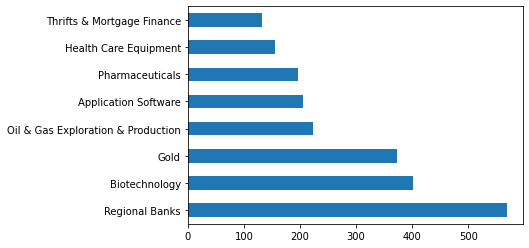

In [ ]:
x['Industry Classification Tag'].value_counts()[:8].plot(kind='barh')

### Encoding the labels

#### Labels to numbers

In [ ]:
label_encoder = preprocessing.LabelEncoder() 

In [ ]:

x['Industry Classification Tag_enc']= label_encoder.fit_transform(x['Industry Classification Tag'])
 

In [ ]:
x['Industry Classification Tag_enc'].unique().size


62

In [ ]:
x.dtypes

Company Name                       object
Business Description               object
Industry Classification Tag        object
Industry Classification Tag_enc     int64
dtype: object

In [ ]:
x.head()

,Company Name,Business Description,Industry Classification Tag,Industry Classification Tag_enc
0,"ADSOUTH PARTNERS, INC.","Adsouth Partners, Inc. provides advertising ag...",Advertising,0
1,"Artec Global Media, Inc.","Artec Global Media, Inc., formerly Artec Consu...",Advertising,0
2,Betawave Corp.,Betawave Corporation provides online marketing...,Advertising,0
3,BOSTON OMAHA Corp,Boston Omaha Corporation is engaged in the bus...,Advertising,0
4,Bright Mountain Media Inc,"Bright Mountain Media, Inc. is a digital media...",Advertising,0


### Shuffling the data so that both the training set and test set can have all the different types of tags 

In [ ]:
from sklearn.utils import shuffle
x = shuffle(x)

In [ ]:
x.reset_index(inplace=True, drop=True)


In [ ]:
x.head()

,Company Name,Business Description,Industry Classification Tag,Industry Classification Tag_enc
0,"Five9, Inc.",Five9 Inc. (Five9) is a provider of cloud soft...,Application Software,4
1,Northeast Indiana Bancorp Inc,"Northeast Indiana Bancorp, Inc. is the holding...",Thrifts & Mortgage Finance,60
2,"Domino's Pizza, Inc.","Domino's Pizza, Inc. is a pizza restaurant cha...",Restaurants,52
3,Coor Service Management Holding AB,Coor Service Management Holding AB is a Sweden...,Diversified Support Services,17
4,BALCHEM CORP,Balchem Corporation is engaged in the developm...,Specialty Chemicals,54


### Split the training data into training set and validation set
#### Training =90%
#### validation= 10%

In [ ]:
split_value=int(0.9 * x.shape[0])
train_data=x.iloc[:split_value]
val_data=x.iloc[split_value:]

In [ ]:
type(train_data)

pandas.core.frame.DataFrame

In [ ]:
train_data['Industry Classification Tag_enc'].unique().size

62

In [ ]:
val_data['Industry Classification Tag_enc'].unique().size

62

### Creating labels and datapoints(sentences)

In [ ]:
training_labels = []
training_sentences=[]

validating_sentences = []
validating_labels = []

test_sentences=[]

In [ ]:
for l in train_data['Business Description']:
  training_sentences.append(l)

In [ ]:
training_sentences = list( map(str, training_sentences) )

In [ ]:
for s in train_data['Industry Classification Tag_enc']:
  training_labels.append(s)

In [ ]:
training_labels_final = np.array(training_labels)
type(training_labels_final[0])

numpy.int64

In [ ]:
for l in val_data['Business Description']:
  validating_sentences.append(l)

In [ ]:
validating_sentences= list( map(str, validating_sentences) )

In [ ]:
for s in val_data['Industry Classification Tag_enc']:
  validating_labels.append(s)

In [ ]:
validation_labels_final = np.array(validating_labels)
type(validation_labels_final[0])

numpy.int64

In [ ]:
for l in y['Business Description']:
  test_sentences.append(l)

In [ ]:
test_sentences = list( map(str, test_sentences) )

In [ ]:
len(training_sentences)

5440

In [ ]:
len(training_labels_final)

5440

### Tokenizing and padding the business description

In [ ]:
vocab_size = 1000
embedding_dim = 19
max_length = 180
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(validating_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [ ]:
padded.shape

(5440, 180)

In [ ]:
training_labels_final.shape

(5440,)

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? northeast <OOV> bancorp inc is the holding company for first federal savings bank the bank the company provides commercial and residential real estate loans in <OOV> <OOV> through the bank it offers an <OOV> of banking and financial advisory services to its customers through over three locations in <OOV> <OOV> the bank offers personal banking services including checking savings <OOV> of deposits health savings accounts retirement accounts credit cards debit cards online banking mobile banking and deposit services it offers business banking services including business checking services business interest checking cash management and merchant deposit capture services the bank's loan portfolio includes commercial mortgage loans construction and land development loans commercial and industrial loans and residential and consumer loans the bank's investment activities are <OOV> as available for sale an

### Deep learning model
#### Various layers with various hyperparameters were applied and the one that has less loss with good accuracy were alone selected. The hyperparameters chosen were purely arbitrary and based on trial and error

In [ ]:

from tensorflow.keras import regularizers


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,input_length=max_length),
    tf.keras.layers.Conv1D(230, 7, activation='relu'),
    
    #tf.keras.layers.Conv1D(128, 7, activation='relu'),
    #tf.keras.layers.MaxPooling1D(2),
    #tf.keras.layers.Conv1D(64, 5, activation='relu'),
    #tf.keras.layers.Conv1D(64, 5, activation='relu'),
    #tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    #tf.keras.layers.Dense(1000, activation='relu'),
    #tf.keras.layers.Dense(750, activation='relu'),
    #tf.keras.layers.Dense(500, activation='relu'),
    #tf.keras.layers.Dense(248, activation='relu'),
    tf.keras.layers.Dense(124, activation='relu'),
    tf.keras.layers.Dense(62, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 180, 19)           19000     
_________________________________________________________________
conv1d (Conv1D)              (None, 174, 230)          30820     
_________________________________________________________________
global_average_pooling1d (Gl (None, 230)               0         
_________________________________________________________________
dropout (Dropout)            (None, 230)               0         
_________________________________________________________________
dense (Dense)                (None, 124)               28644     
_________________________________________________________________
dense_1 (Dense)              (None, 62)                7750      
Total params: 86,214
Trainable params: 86,214
Non-trainable params: 0
____________________________________________________

### Training the model

In [ ]:
num_epochs = 80
history = model.fit(padded, training_labels_final, epochs=num_epochs,validation_data=(testing_padded, validation_labels_final))

Epoch 1/80
170/170 [==============================] - 2s 10ms/step - loss: 3.7197 - accuracy: 0.1322 - val_loss: 3.2905 - val_accuracy: 0.2165
Epoch 2/80
170/170 [==============================] - 1s 7ms/step - loss: 3.0104 - accuracy: 0.2577 - val_loss: 2.8075 - val_accuracy: 0.2826
Epoch 3/80
170/170 [==============================] - 1s 7ms/step - loss: 2.6216 - accuracy: 0.3083 - val_loss: 2.5518 - val_accuracy: 0.3041
Epoch 4/80
170/170 [==============================] - 1s 7ms/step - loss: 2.3975 - accuracy: 0.3355 - val_loss: 2.4035 - val_accuracy: 0.3174
Epoch 5/80
170/170 [==============================] - 1s 8ms/step - loss: 2.2945 - accuracy: 0.3480 - val_loss: 2.3877 - val_accuracy: 0.3223
Epoch 6/80
170/170 [==============================] - 1s 8ms/step - loss: 2.2030 - accuracy: 0.3627 - val_loss: 2.3522 - val_accuracy: 0.3091
Epoch 7/80
170/170 [==============================] - 1s 8ms/step - loss: 2.1294 - accuracy: 0.3800 - val_loss: 2.3286 - val_accuracy: 0.3339
Epoch

### Plotting accuracy and loss graphs for both train and validation set

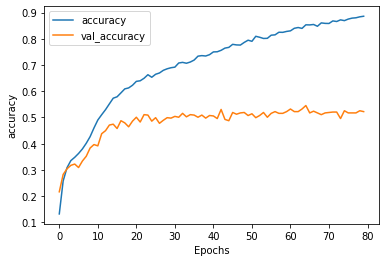

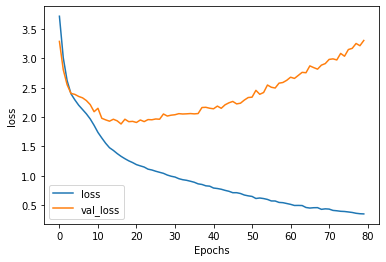

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### F1 score and AUC score

In [ ]:
y_pred_train=model.predict_classes(padded)
y_pred_val=model.predict_classes(testing_padded)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
y_true_train=x['Industry Classification Tag_enc'].iloc[:5440]
y_true_val=x['Industry Classification Tag_enc'].iloc[5440:]
y_true_train=np.asarray(y_true_train)
y_true_val=np.asarray(y_true_val)

In [ ]:
from sklearn.metrics import f1_score
from sklearn import metrics

In [ ]:
print('F1 score for training set',f1_score(y_true_train, y_pred_train,average='micro'))
print('F1 score for validation set',f1_score(y_true_val, y_pred_val, average='micro'))
fpr, tpr, thresholds = metrics.roc_curve(y_true_train, y_pred_train, pos_label=2)
print('AUC score for Training set',metrics.auc(fpr, tpr))
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_true_val, y_pred_val, pos_label=2)
print('AUC score for Validation set',metrics.auc(fpr2, tpr2))

F1 score for training set 0.9419117647058823
F1 score for validation set 0.5223140495867769
AUC score for Training set 0.03330859157543142
AUC score for Validation set 0.03308647873865263


In [ ]:
#AUC_train=metrics.roc_auc_score(y_true_val, y_pred_val, average='macro', multi_class='ovo')

### Implementing the code on Test data

In [ ]:
vocab_size = 1000
embedding_dim = 19
max_length = 180
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(test_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(test_sentences)
test_set_padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


In [ ]:
results=model.predict_classes(test_set_padded)

In [ ]:
test_set_padded.shape

(772, 180)

In [ ]:
results.shape

(772,)

In [ ]:
results=pd.DataFrame(results)
results.columns=['tag']
results.reset_index(drop=True)

,tag
0,47
1,49
2,14
3,21
4,39
...,...
767,31
768,40
769,54
770,21


In [ ]:
y['Industry Classification Tag_dec']=results
y.head()

,Company,Business Description,Industry Classification Tag_dec
0,3rd Rock Multimedia Ltd,3rd Rock Multimedia Limited is an India-based ...,47
1,Andhra Petrochemicals Ltd,The Andhra Petrochemicals Limited is an India-...,49
2,Force Motors Ltd,Force Motors Limited is a holding company. The...,14
3,Diamines And Chemicals Ltd,Diamines and Chemicals Limited is a holding co...,21
4,Insilco Ltd,Insilco Limited is engaged in manufacturing an...,39


### Decoding the tags

In [ ]:
y['Industry Classification Tag']= label_encoder.inverse_transform(y['Industry Classification Tag_dec'])

In [ ]:
y['Industry Classification Tag'].value_counts().size

61

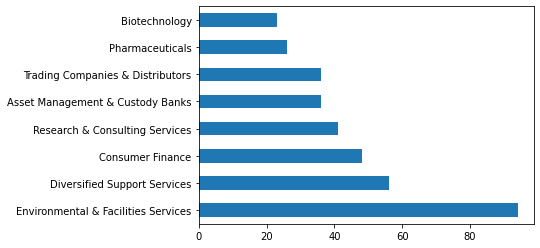

In [ ]:
y['Industry Classification Tag'].value_counts()[:8].plot(kind='barh')

## From the results it is very obvious that the BERT model performs better than the previous one but it is  computationally expensive. 